In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

# load the CLIP model
model = SentenceTransformer('clip-ViT-B-32')

Downloading: 100%|██████████| 690/690 [00:00<00:00, 298kB/s]
Downloading: 100%|██████████| 4.03k/4.03k [00:00<00:00, 1.52MB/s]
Downloading: 100%|██████████| 525k/525k [00:01<00:00, 305kB/s]  
Downloading: 100%|██████████| 316/316 [00:00<00:00, 102kB/s]
Downloading: 100%|██████████| 605M/605M [01:02<00:00, 9.76MB/s] 
Downloading: 100%|██████████| 604/604 [00:00<00:00, 217kB/s]
Downloading: 100%|██████████| 961k/961k [00:02<00:00, 376kB/s]  
Downloading: 100%|██████████| 1.88k/1.88k [00:00<00:00, 2.34MB/s]
Downloading: 100%|██████████| 122/122 [00:00<00:00, 141kB/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [2]:
# get 25k images from Unsplash
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)

    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):  # Download dataset if it doesn't exist
        util.http_get('http://sbert.net/datasets/' + photo_filename, photo_filename)

    # extract images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)

100%|██████████| 1.92G/1.92G [05:06<00:00, 6.27MB/s]  
Extracting: 100%|██████████| 24996/24996 [00:08<00:00, 2881.18it/s]


In [3]:
# compute the embeddings
# distribute pre-computed embeddings
# otherwise, can also encode images yourself
# to encode the image:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings:
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):    # download dataset if it doesn't exist
        util.http_get('http://sbert.net/datasets/' + emb_filename, emb_filename)

    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)
    print("len(img_names): ", len(img_names))
else:
    img_names = list(glob.glob('unsplash/photos/*.jpg'))
    print('len(img_names): ', len(img_names))
    img_emb = model.encode(
        [Image.open(filepath) for filepath in img_names],
        batch_size=128,
        convert_to_tensor=True,
        show_progress_bar=True)

100%|██████████| 51.8M/51.8M [00:37<00:00, 1.37MB/s]

len(img_names):  24996


In [4]:
# now run clustering algorithm on images
# with the threshold parameter, we define at which threshold we identify
# two images as similar. Set the threshold lower, and you will get larger clusters which have
# less similar images in it (e.g. black cat images vs. cat images vs. animal images).
# with min_community_size, we define that we only want to have clusters of a certain minimal size

duplicates = util.paraphrase_mining_embeddings(img_emb)

# duplicates contains a list with triplets (score, image_id1, image_id2) and is sorted in decreasing order


Score: 1.000
0UtMDLOk0Vg.jpg


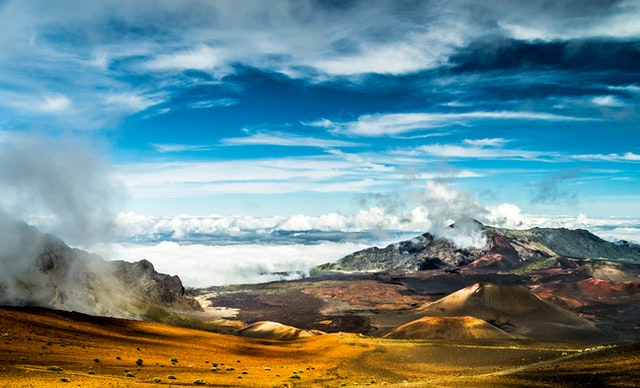

10OY7Od4YeQ.jpg


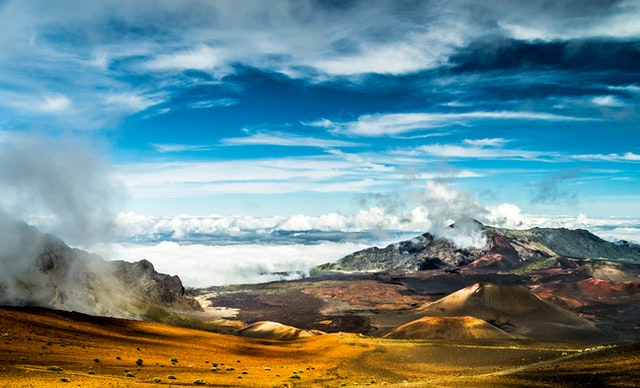


Score: 1.000
fPipNm8A5uc.jpg


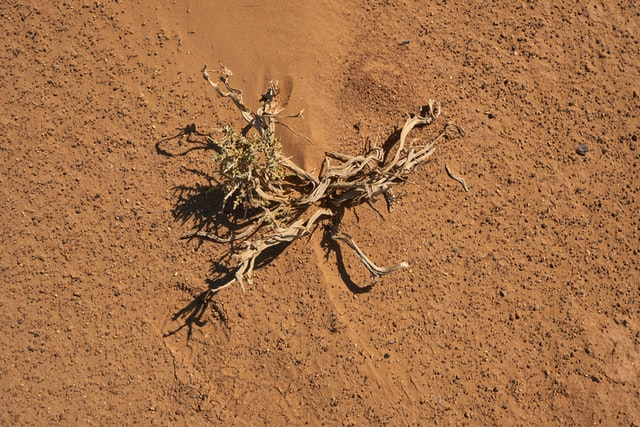

cSSWEsnYv7w.jpg


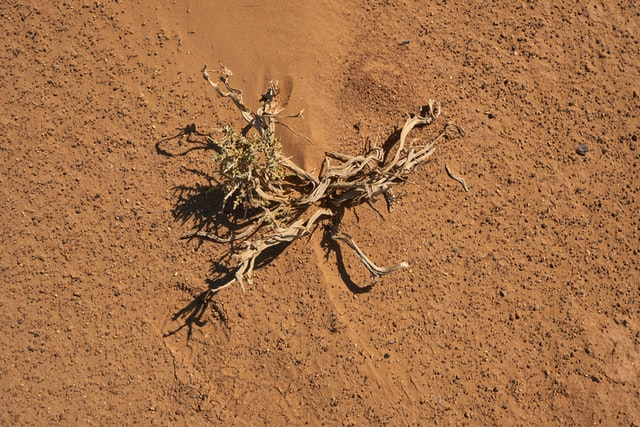


Score: 1.000
4f4e3hRnwKs.jpg


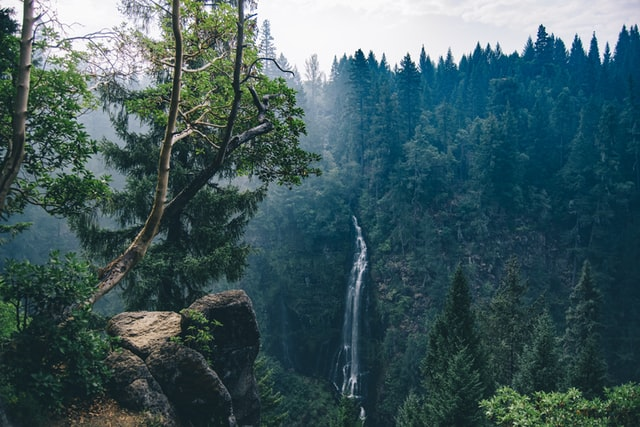

f3hDGOHptrM.jpg


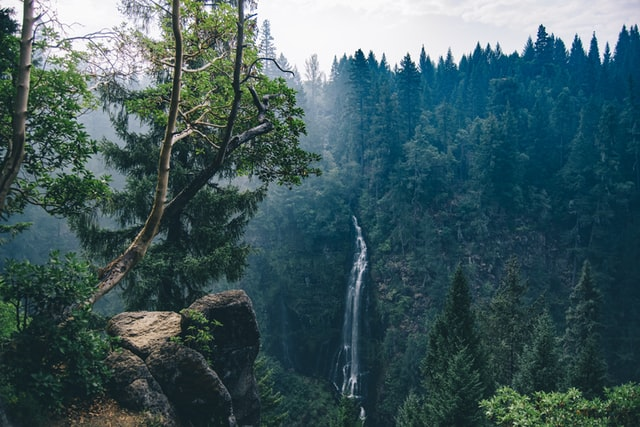


Score: 1.000
tt2Oui1hKAM.jpg


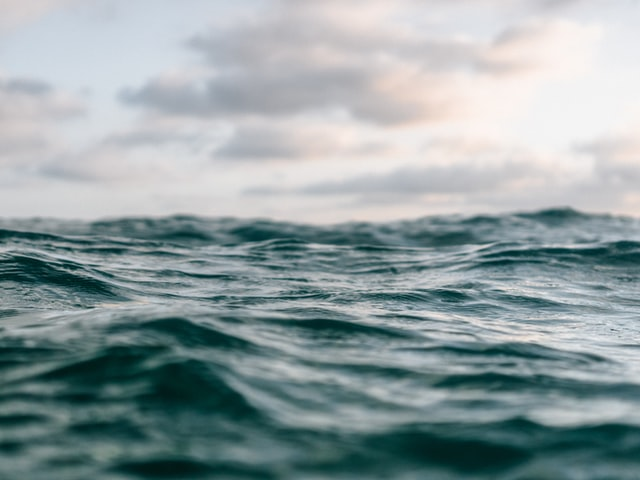

4KV3SKyHNjE.jpg


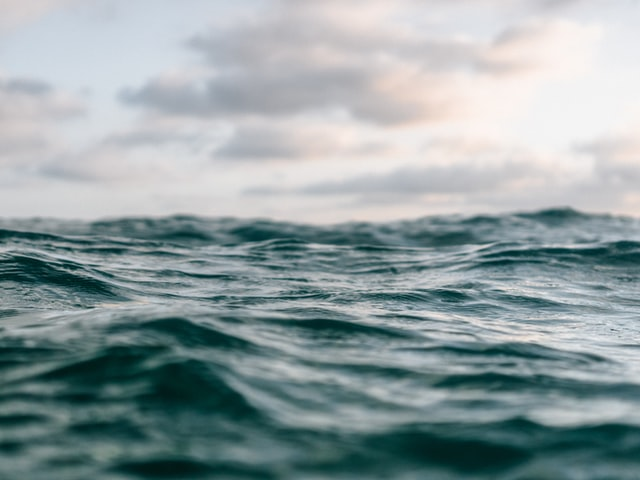


Score: 1.000
s1i4hmEtOGE.jpg


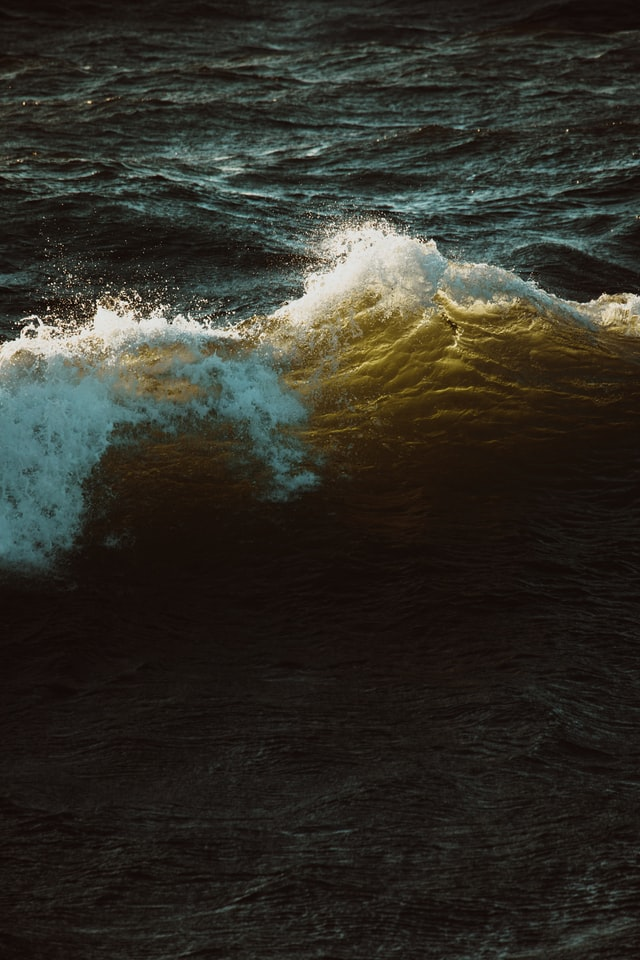

vY0o82ygEsU.jpg


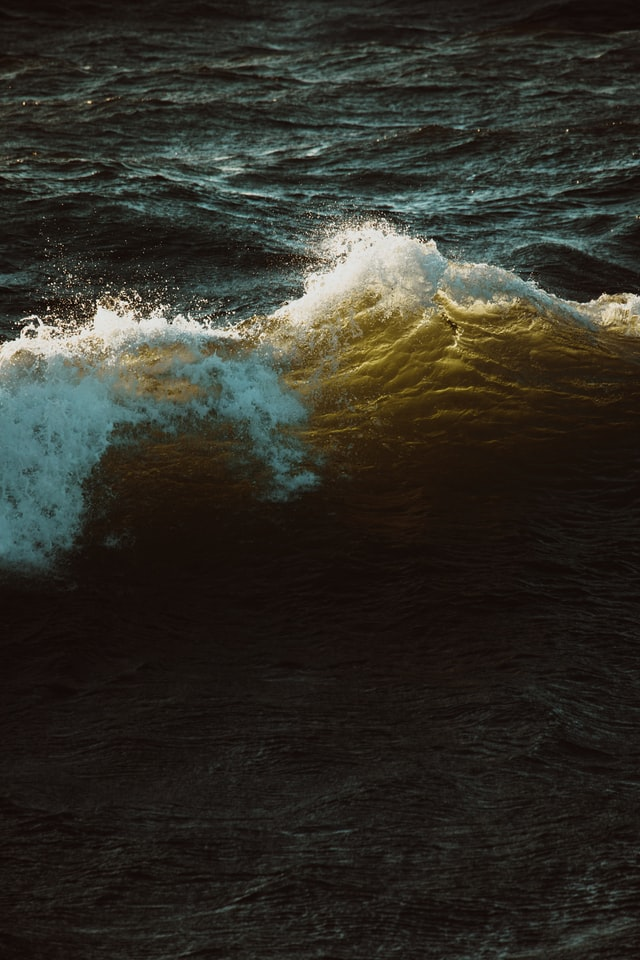


Score: 1.000
xm6esles7ds.jpg


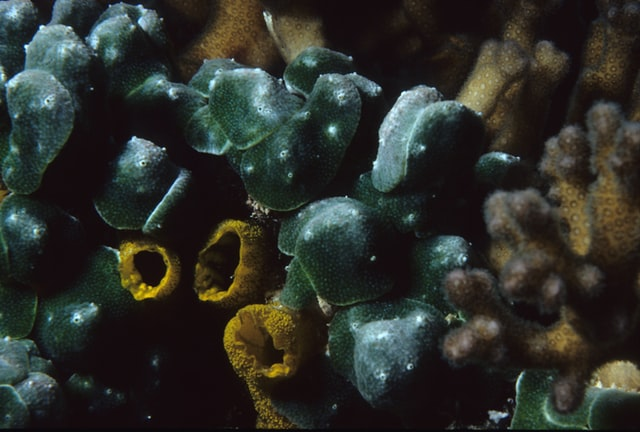

CkwM5Mrnd8U.jpg


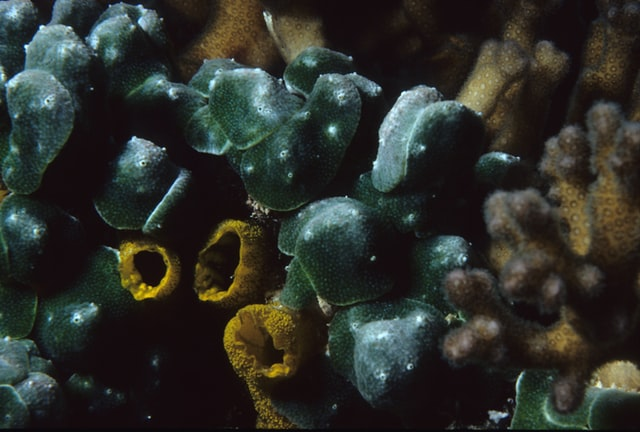


Score: 1.000
QO4Y97jiVDQ.jpg


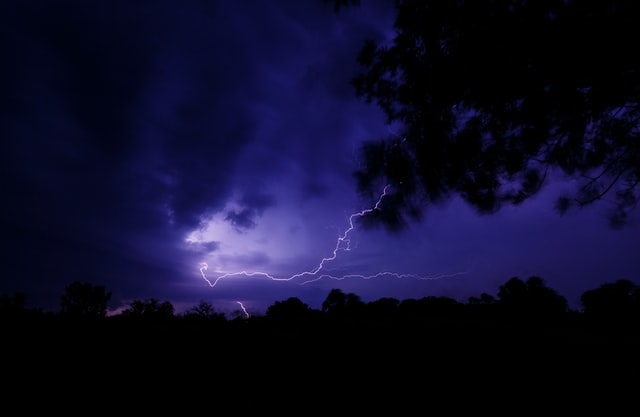

0ETSZYPjvDo.jpg


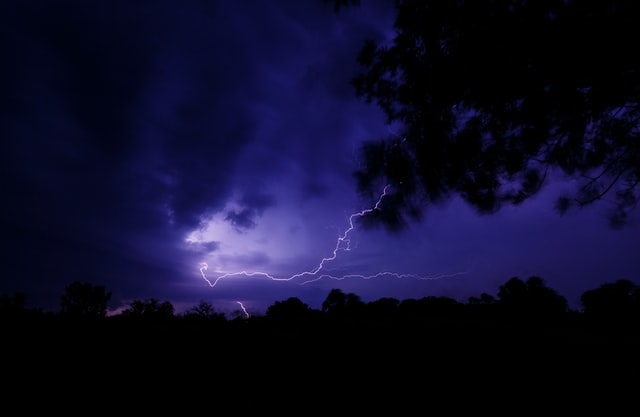


Score: 1.000
LYycu62H2-8.jpg


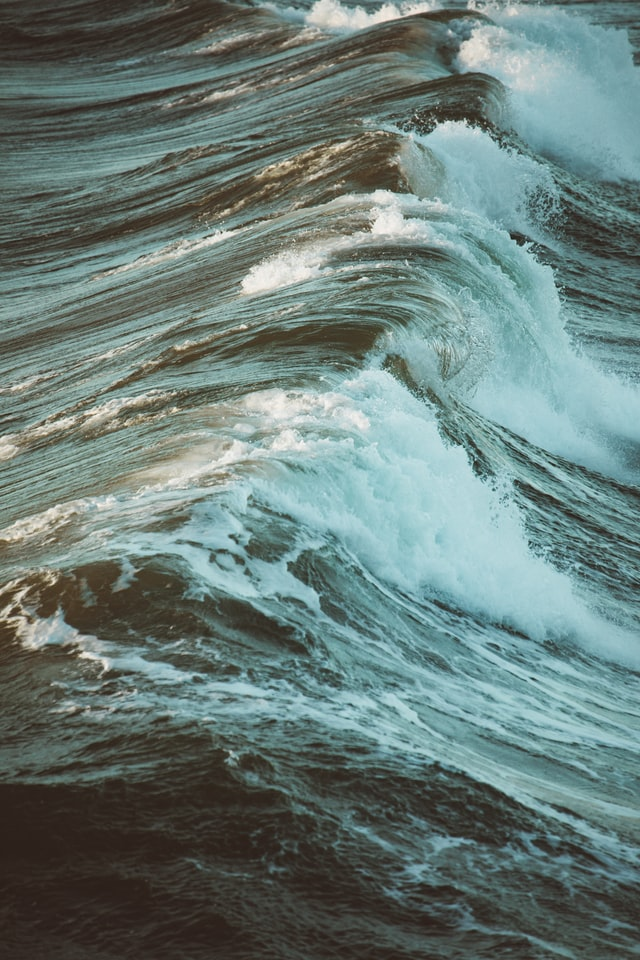

s5_rlPwwads.jpg


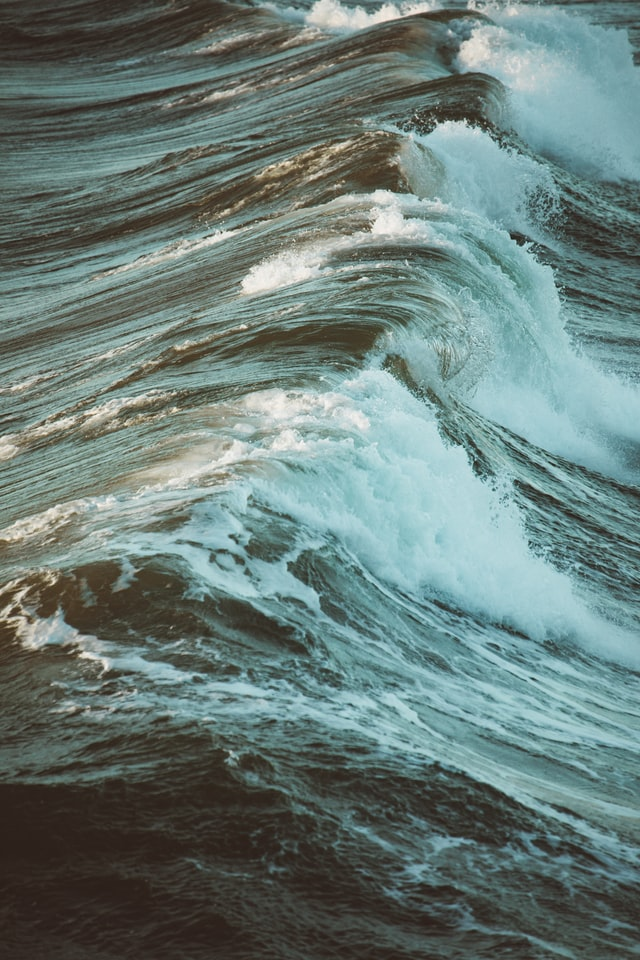


Score: 1.000
RadJczno8RA.jpg


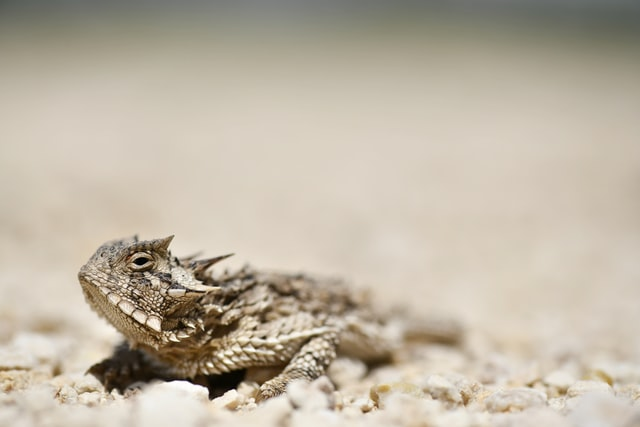

fmTDdLOEkl0.jpg


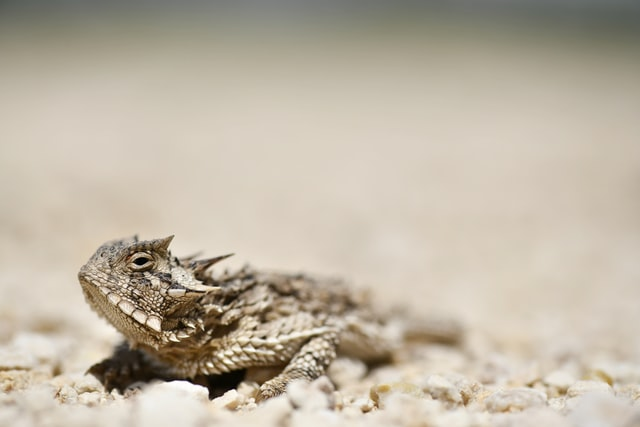


Score: 1.000
D5HcvD3a6uM.jpg


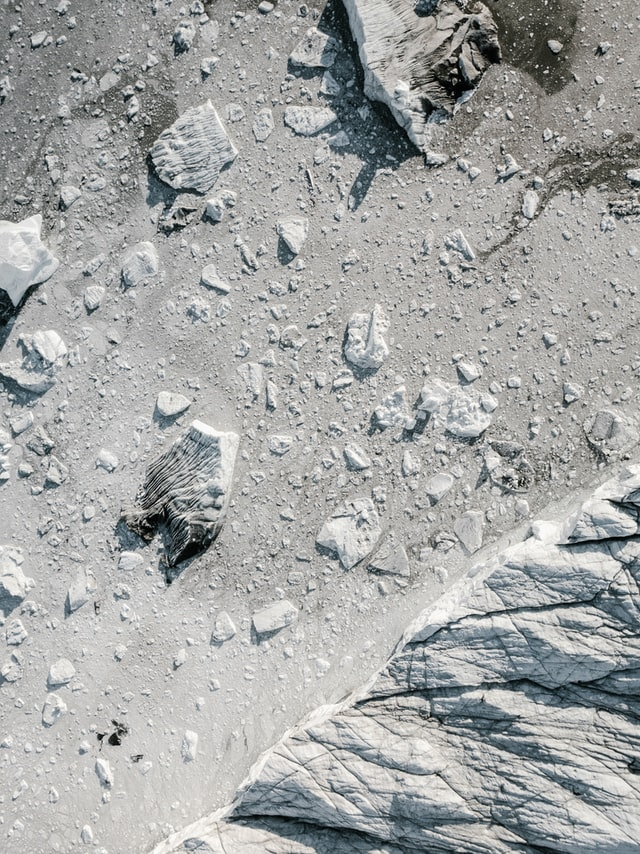

eyB95KJ2zK0.jpg


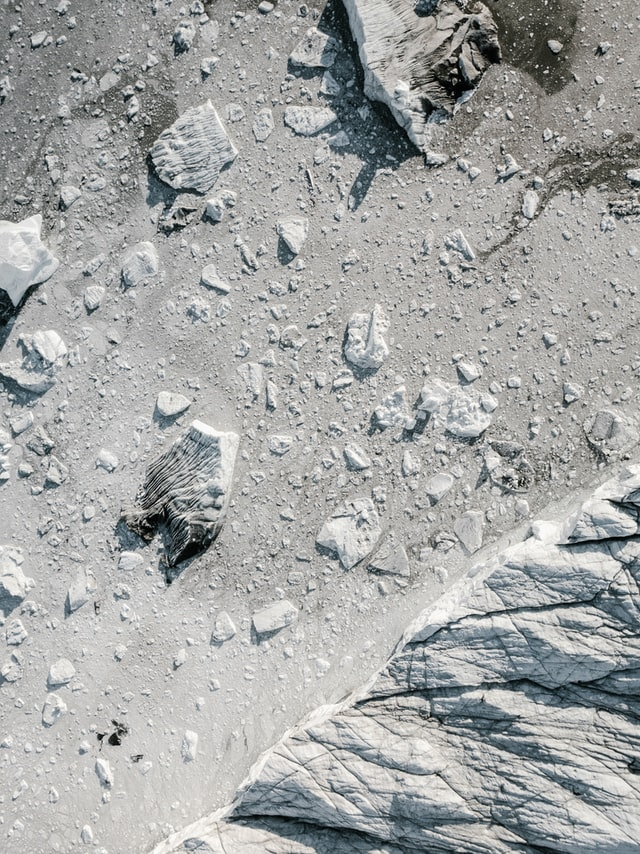

In [5]:
# call the top 10 most similar images in the dataset. These are identical images, for example, the same
# photo was uploaded twice to unsplash

for score, idx1, idx2 in duplicates[0:10]:
    print('\nScore: {:.3f}'.format(score))
    print(img_names[idx1])
    display(IPImage(os.path.join(img_folder, img_names[idx1]), width=200))
    print(img_names[idx2])
    display(IPImage(os.path.join(img_folder, img_names[idx2]), width=200))